
## captions are strictly mandatory: no captions no points. The discussion of what you do is the ultimate deliverable of each task

Captions need to describe: what is plotted and what is interesting about it


PLEASE REMEMBER: download your data in a reproducible way, seed your random functions if you need to use any, label your axes clearly, captions for each figure that explains what is shown, and what is noticeable about it, comment your code.






## respect coding standards
*The [following PEP8 rules](https://docs.google.com/document/d/1-XnKK4xRBA5FXOBa4p0Z4in7qfVyk4CutjSMEX-jpTQ/edit?usp=sharing) are now required*

Points will be taken off if they are violated

## problem statement

** An interesting and popular urban science question is "can we measure and predict energy use based on observables that are easily acquired". For example the urban observatory at CUSP can monitor lights: they are a relatively easy observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.**

** So let's test if the last link holds. If we have data on the _energy consumed by a building_ how well does that relate to the _number of units_ in the building?**

** Data on energy consumption can be found here for the city of NY https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z  **

** Either obtain the data through the API or download the csv file, and move it to $PUIDATA**

** However this datasets does not have the number of units. We can find that in the [Pluto dataset](https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page).**

** Reading in the Pluto data for manhattan, which will give me the number of units ber building   Manhattan/MNMapPLUTO.shp ** Note that you should keep all the files in the original MNMapPluto zipped folder (not just the .shp file) for geopandas to read the data in correctly.

# data acquisition

## download, move data to $PUIDATA, and read data in 
make sure you limit the PLUTO dataset to Manhattan, The entire NYC PLUTO dataset is huge!

Hint: borough = 'Manhattan'

...download...

In [1]:
import os
import json
import pandas as pd
import urllib
import geopandas as gp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pylab as pl
%pylab inline
import statsmodels.formula.api as smf

Populating the interactive namespace from numpy and matplotlib


In [2]:
#setting PUIDATA environment variable

os.environ["PUIDATA"] = "%s/001_PUI/PUIDATA"%os.getenv("HOME")
print("Path to PUIDATA", os.getenv("PUIDATA"))

Path to PUIDATA /nfshome/qg412/001_PUI/PUIDATA


In [3]:
!curl https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv > Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4329k    0 4329k    0     0  18.8M      0 --:--:-- --:--:-- --:--:-- 18.7M


In [4]:
!mv 'Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv' $PUIDATA

In [5]:
# learning point: i used curl and it crashed adrf. urllib is more stable! 

url = 'https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_18v1.zip'

urllib.request.urlretrieve(url, "mn_mappluto_18v1.zip")

('mn_mappluto_18v1.zip', <http.client.HTTPMessage at 0x7f14782a1550>)

In [6]:
os.system("unzip " "mn_mappluto_18v1.zip" + " -d " + os.getenv('PUIDATA'))

256

In [7]:
# moving it away because I dont want to upload data into github
!mv 'mn_mappluto_18v1.zip' $PUIDATA

In [8]:
# load the buildinmg size as a geoDF and the local law 84 as a dtaframe
nrg = pd.read_csv(os.getenv("PUIDATA") + 
                  "/Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv")

bsize = gp.GeoDataFrame.from_file(os.getenv("PUIDATA") + "/MNMapPLUTO.shp")

## exploring the data a bit

As we discussed, coming up with a sensible model generally requires domain expertise. However, if the data you are investigating shows "obvious patterns", for example if two of the variable look like a line when plotted one against the other, then those patterns (correlations) may help you finding reasonable models for the data.

Explore your data, starting with a scatter matrix. 
A scatter matrix is a plot of all variables in your data against all other variables: 
each pair of variables is a subplot in the plot matrix. The diagonal line then would be a plot of a variable against itself, which is useless, so it is usually substituted by a histogram of that variable (or sometimes a KDE, which is basically a smooth histogram).

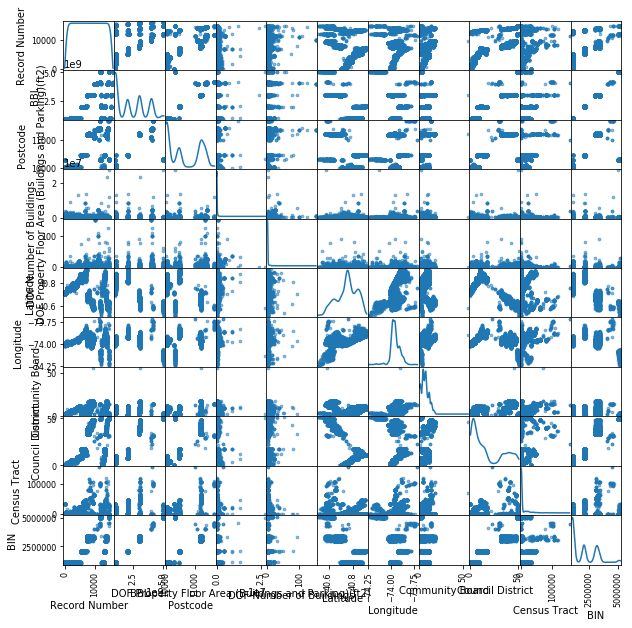

In [9]:
sfig = pd.scatter_matrix(nrg, s=30, figsize=(10, 10), diagonal='kde') 
#the code above gives an output containing all the subplots, so to show it all we need to do is to plt.show it!  

plt.show()

Figure 1: Scatter matrix showing plots of all variables pairs in energy and water consumption as disclosed in the year of 2013.  

This kind of plot shows correlations between variables, but it will also show me what can and cannot be plotted trivially in my dataset. Here only a few columns can be plotted: those that contain only numbers (and possibly NaN's), but most columns contain rows that cannot be converted to float (e.g. entries like 'See Primary BBL' in several rows for the energy dataframe 'Site EUI(kBtu/ft2) ' column) , so Pandas refuses to plot them, cause it does not know what to do with those entries. The columns I am interested in are in fact u'Site EUI(kBtu/ft2)' which is a measure of the energy consumed PER SQ FOOT by a building, and then the building area: for eg. u'Reported Property Floor Area (Building(s)) (ft²)'. Neither gets plotted: I need to remove all values that cannot convert to float in order to use the columns and convert them to float arrays and do math with them.

You can use pd.to_numeric() which is a function that transforms values to float (when possible). The default behavior of this function is to throw an error if it encounters a value that it cannot convert. That behavior can be modified with the "error" keyword, by setting it to "coerce". Please look at the function documentation to understand the syntax.

## data cleaning and aggregation 
### checking the content of the datasets


clean up columns I am not using: for my solution, I will keep  BBL, 'Site EUI(kBtu/ft2)', 'Reported Property Floor Area (Building(s)) (ft²)' from the energy dataframe, and BBL , UnitsTotal, UnitsRes, 'YearBuilt', and 'geometry' from the PLUTO geodaraframe

### remove what you do not need

In [10]:
nrg.columns

Index(['Record Number', 'BBL', 'Co-reported BBL Status', 'BBLs Co-reported',
       'Reported NYC Building Identificaiton Numbers (BINs)', 'Street Number',
       'Street Name', 'Borough', 'Postcode',
       'DOF Benchmarking Submission Status', 'Site EUI(kBtu/ft2)',
       'Weather Normalized Site EUI(kBtu/ft2)', 'Source EUI(kBtu/ft2)',
       'Weather Normalized Source EUI(kBtu/ft2)',
       'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       'Automatic Water Benchmarking Eligible', 'Reported Water Method',
       'ENERGY STAR Score', 'Total GHG Emissions(MtCO2e)',
       'Direct GHG Emissions(MtCO2e)', 'Indirect GHG Emissions(MtCO2e)',
       'Reported Property Floor Area (Building(s)) (ft²)',
       'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       'Primary Property Type - Self Selected', 'DOF Number of Buildings',
       'Latitude', 'Longitude', 'Community Board', 'Council District',
       'Census Tract', 'BIN', 'NTA'],
      dtype='object')

In [11]:
#dropping unwanted columns
nrg.drop(['Record Number', 'Co-reported BBL Status', 'BBLs Co-reported',
       'Reported NYC Building Identificaiton Numbers (BINs)', 'Street Number',
       'Street Name', 'Borough', 'Postcode',
       'DOF Benchmarking Submission Status',
       'Weather Normalized Site EUI(kBtu/ft2)', 'Source EUI(kBtu/ft2)',
       'Weather Normalized Source EUI(kBtu/ft2)',
       'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       'Automatic Water Benchmarking Eligible', 'Reported Water Method',
       'ENERGY STAR Score', 'Total GHG Emissions(MtCO2e)',
       'Direct GHG Emissions(MtCO2e)', 'Indirect GHG Emissions(MtCO2e)',
       'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       'Primary Property Type - Self Selected', 'DOF Number of Buildings',
       'Latitude', 'Longitude', 'Community Board', 'Council District',
       'Census Tract', 'BIN', 'NTA'], axis=1, inplace=True)

In [12]:
#leave
nrg.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²)
0,1.000410e+09,NaN,918919
1,4.021460e+09,NaN,NaN
2,2.027620e+09,NaN,64200
3,1.006700e+09,NaN,NaN
4,2.048300e+09,NaN,50000


In [13]:
bsize.columns.sort_values()

Index(['APPBBL', 'APPDate', 'Address', 'AreaSource', 'AssessLand', 'AssessTot',
       'BBL', 'BldgArea', 'BldgClass', 'BldgDepth', 'BldgFront', 'Block',
       'BoroCode', 'Borough', 'BsmtCode', 'BuiltFAR', 'CB2010', 'CD', 'CT2010',
       'ComArea', 'CommFAR', 'CondoNo', 'Council', 'EDesigNum', 'Easements',
       'ExemptLand', 'ExemptTot', 'Ext', 'FIRM07_FLA', 'FacilFAR',
       'FactryArea', 'FireComp', 'GarageArea', 'HealthArea', 'HealthCent',
       'HistDist', 'IrrLotCode', 'LandUse', 'Landmark', 'Lot', 'LotArea',
       'LotDepth', 'LotFront', 'LotType', 'LtdHeight', 'MAPPLUTO_F',
       'NumBldgs', 'NumFloors', 'OfficeArea', 'OtherArea', 'Overlay1',
       'Overlay2', 'OwnerName', 'OwnerType', 'PFIRM15_FL', 'PLUTOMapID',
       'PolicePrct', 'ProxCode', 'ResArea', 'ResidFAR', 'RetailArea',
       'SHAPE_area', 'SHAPE_len', 'SPDist1', 'SPDist2', 'SPDist3', 'Sanborn',
       'SanitBoro', 'SanitDistr', 'SanitSub', 'SchoolDist', 'SplitZone',
       'StrgeArea', 'TaxMap', 'Tract201

In [14]:
#dropping unwanted columns
bsize.drop(['APPBBL', 'APPDate', 'Address', 'AreaSource', 'AssessLand', 'AssessTot',
       'BldgArea', 'BldgClass', 'BldgDepth', 'BldgFront', 'Block',
       'BoroCode', 'Borough', 'BsmtCode', 'BuiltFAR', 'CB2010', 'CD', 'CT2010',
       'ComArea', 'CommFAR', 'CondoNo', 'Council', 'EDesigNum', 'Easements',
       'ExemptLand', 'ExemptTot', 'Ext', 'FIRM07_FLA', 'FacilFAR',
       'FactryArea', 'FireComp', 'GarageArea', 'HealthArea', 'HealthCent',
       'HistDist', 'IrrLotCode', 'LandUse', 'Landmark', 'Lot', 'LotArea',
       'LotDepth', 'LotFront', 'LotType', 'LtdHeight', 'MAPPLUTO_F',
       'NumBldgs', 'NumFloors', 'OfficeArea', 'OtherArea', 'Overlay1',
       'Overlay2', 'OwnerName', 'OwnerType', 'PFIRM15_FL', 'PLUTOMapID',
       'PolicePrct', 'ProxCode', 'ResArea', 'ResidFAR', 'RetailArea',
       'SHAPE_area', 'SHAPE_len', 'SPDist1', 'SPDist2', 'SPDist3', 'Sanborn',
       'SanitBoro', 'SanitDistr', 'SanitSub', 'SchoolDist', 'SplitZone',
       'StrgeArea', 'TaxMap', 'Tract2010', 'Version',
       'XCoord', 'YCoord', 'YearAlter1', 'YearAlter2', 'ZMCode',
       'ZipCode', 'ZoneDist1', 'ZoneDist2', 'ZoneDist3', 'ZoneDist4',
       'ZoneMap'], axis=1, inplace=True)

In [15]:
bsize.head()

,UnitsRes,UnitsTotal,YearBuilt,BBL,geometry
0,16,18,1920,1.015450e+09,"POLYGON ((997277.2344360352 221816.0936279297,..."
1,50,50,1914,1.007238e+09,"POLYGON ((984164.5626220703 211846.0704345703,..."
2,10,10,1910,1.016800e+09,"POLYGON ((1000742.195800781 227910.6640014648,..."
3,29,32,1928,1.013850e+09,"POLYGON ((994007.6885986328 219880.4284057617,..."
4,26,26,1900,1.011970e+09,"POLYGON ((992273.6849975586 224863.4904174805,..."


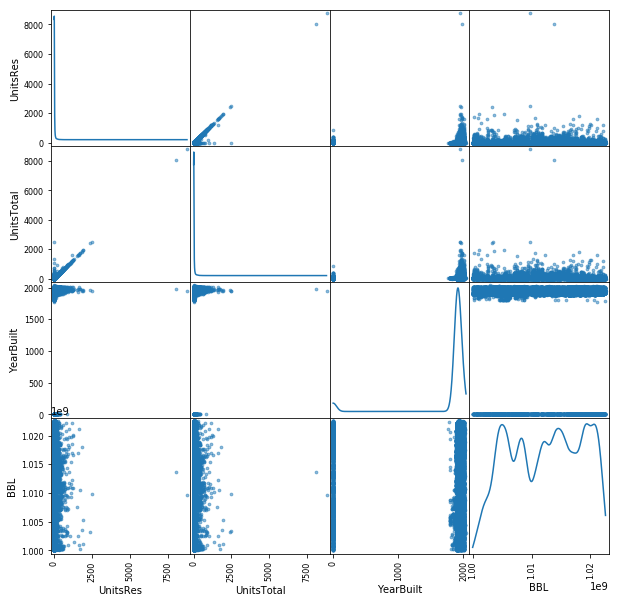

In [16]:
sfig = pd.scatter_matrix(bsize, s=30, figsize=(10, 10), diagonal='kde')

plt.show()

Figure 2: Scatterplot matrix showing variables pair plots in the Manhattan Pluto dataset. 

## converting  the relevant columns to numeric values and throwing away spurious entries

use pd.to_numeric() to convert strings to numeric values, remember the keyword "errors" which will be useful


In [17]:
nrg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16170 entries, 0 to 16169
Data columns (total 3 columns):
BBL                                                 16014 non-null float64
Site EUI(kBtu/ft2)                                  12204 non-null object
Reported Property Floor Area (Building(s)) (ft²)    13785 non-null object
dtypes: float64(1), object(2)
memory usage: 379.1+ KB


In [18]:
bsize.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 42556 entries, 0 to 42555
Data columns (total 5 columns):
UnitsRes      42556 non-null int64
UnitsTotal    42556 non-null int64
YearBuilt     42556 non-null int64
BBL           42556 non-null float64
geometry      42556 non-null object
dtypes: float64(1), int64(3), object(1)
memory usage: 1.6+ MB


In [19]:
len(nrg)

16170

In [20]:
nrg.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²)
0,1.000410e+09,NaN,918919
1,4.021460e+09,NaN,NaN
2,2.027620e+09,NaN,64200
3,1.006700e+09,NaN,NaN
4,2.048300e+09,NaN,50000


In [21]:
nrg['BBL'].unique()

array([  1.00041000e+09,   4.02146003e+09,   2.02762010e+09, ...,
         1.01486005e+09,   2.03619000e+09,   2.03843000e+09])

In [22]:
#converting string to float. 
nrg['Site EUI(kBtu/ft2)'] = pd.to_numeric(nrg['Site EUI(kBtu/ft2)'], errors='coerce')

nrg['Reported Property Floor Area (Building(s)) (ft²)'] = pd.to_numeric(nrg['Reported Property Floor Area (Building(s)) (ft²)'], errors='coerce')

In [23]:
## checking that the conversion worked:
nrg['Site EUI(kBtu/ft2)'].astype(float)[:10], bsize.BBL.astype(float)[:10]

(0   NaN
 1   NaN
 2   NaN
 3   NaN
 4   NaN
 5   NaN
 6   NaN
 7   NaN
 8   NaN
 9   NaN
 Name: Site EUI(kBtu/ft2), dtype: float64, 0    1.015450e+09
 1    1.007238e+09
 2    1.016800e+09
 3    1.013850e+09
 4    1.011970e+09
 5    1.002360e+09
 6    1.008370e+09
 7    1.001960e+09
 8    1.022240e+09
 9    1.011270e+09
 Name: BBL, dtype: float64)

In [24]:
##check that your conversion worked: e.g.
print ("number of missing energy observations:", np.isnan(nrg['Site EUI(kBtu/ft2)'].astype(float)).sum())

number of missing energy observations: 4623


In [25]:
##check that your conversion worked: e.g.
print ("fraction of missing energy observations: %.2f"%(np.isnan(nrg['Site EUI(kBtu/ft2)'].astype(float)).sum() /
      len(nrg['Site EUI(kBtu/ft2)'])))

fraction of missing energy observations: 0.29


 ## merge the 2 datasets
 I can merge the dataframes on NYC Borough, Block, and Lot: BBL

In [26]:
nrg.head()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²)
0,1.000410e+09,NaN,918919.0
1,4.021460e+09,NaN,NaN
2,2.027620e+09,NaN,64200.0
3,1.006700e+09,NaN,NaN
4,2.048300e+09,NaN,50000.0


In [27]:
bsize.head()

,UnitsRes,UnitsTotal,YearBuilt,BBL,geometry
0,16,18,1920,1.015450e+09,"POLYGON ((997277.2344360352 221816.0936279297,..."
1,50,50,1914,1.007238e+09,"POLYGON ((984164.5626220703 211846.0704345703,..."
2,10,10,1910,1.016800e+09,"POLYGON ((1000742.195800781 227910.6640014648,..."
3,29,32,1928,1.013850e+09,"POLYGON ((994007.6885986328 219880.4284057617,..."
4,26,26,1900,1.011970e+09,"POLYGON ((992273.6849975586 224863.4904174805,..."


In [28]:
bblnrgdataGPD = pd.merge(bsize, nrg, on='BBL')

In [29]:
bblnrgdata = bblnrgdataGPD.drop('geometry', axis=1) #for portability, they say

In [30]:
bblnrgdata.head()

,UnitsRes,UnitsTotal,YearBuilt,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²)
0,50,50,1914,1.007238e+09,68.7,95844.0
1,29,32,1928,1.013850e+09,87.4,206989.0
2,72,72,1923,1.021740e+09,140.4,52920.0
3,107,108,1931,1.008830e+09,96.5,98359.0
4,134,138,1910,1.008570e+09,36.4,154000.0


# Plot the data as a choropleth for the 2 quantities of interest: number of units and energy consumed energy

uhm... what is energy consumed energy supposed to mean

In [31]:
bblnrgdataGPD.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 6438 entries, 0 to 6437
Data columns (total 7 columns):
UnitsRes                                            6438 non-null int64
UnitsTotal                                          6438 non-null int64
YearBuilt                                           6438 non-null int64
BBL                                                 6438 non-null float64
geometry                                            6438 non-null object
Site EUI(kBtu/ft2)                                  5047 non-null float64
Reported Property Floor Area (Building(s)) (ft²)    5545 non-null float64
dtypes: float64(3), int64(3), object(1)
memory usage: 402.4+ KB


In [32]:
bblnrgdataGPD.head()

,UnitsRes,UnitsTotal,YearBuilt,BBL,geometry,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²)
0,50,50,1914,1.007238e+09,"POLYGON ((984164.5626220703 211846.0704345703,...",68.7,95844.0
1,29,32,1928,1.013850e+09,"POLYGON ((994007.6885986328 219880.4284057617,...",87.4,206989.0
2,72,72,1923,1.021740e+09,"POLYGON ((1004080.155029297 252930.9956054688,...",140.4,52920.0
3,107,108,1931,1.008830e+09,"POLYGON ((989337.639831543 209686.7838134766, ...",96.5,98359.0
4,134,138,1910,1.008570e+09,"POLYGON ((988035.3540039062 210290.9854125977,...",36.4,154000.0


In [33]:
#dropping nan
bblnrgdataGPD['Reported Property Floor Area (Building(s)) (ft²)'] = bblnrgdataGPD['Reported Property Floor Area (Building(s)) (ft²)'].dropna()
bblnrgdataGPD['Site EUI(kBtu/ft2)'] = bblnrgdataGPD['Site EUI(kBtu/ft2)'].dropna()

In [34]:
# dropping 0
bblnrgdataGPD = bblnrgdataGPD[bblnrgdataGPD['Reported Property Floor Area (Building(s)) (ft²)'] > 0]
bblnrgdataGPD = bblnrgdataGPD[bblnrgdataGPD['Site EUI(kBtu/ft2)'] > 0]

In [35]:
bblnrgdataGPD['logarea'] = np.log10(bblnrgdataGPD['Reported Property Floor Area (Building(s)) (ft²)']+1)

In [36]:
bblnrgdataGPD['lognrg'] =  np.log10(bblnrgdataGPD['Site EUI(kBtu/ft2)'])

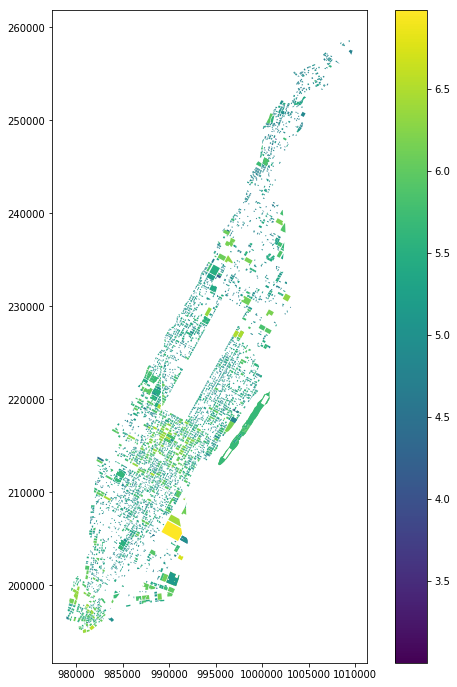

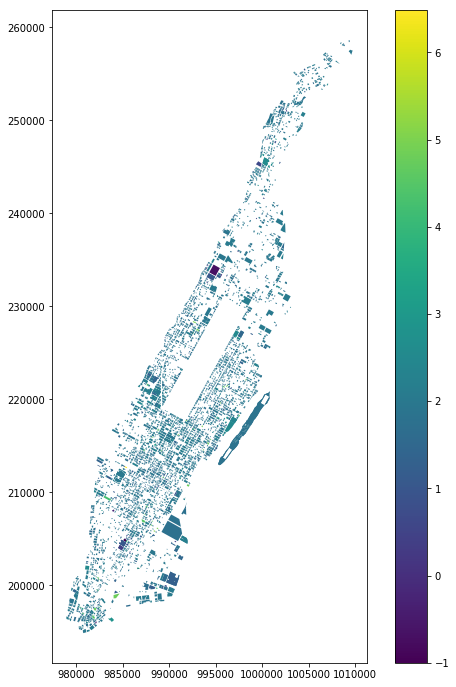

In [37]:
ax = bblnrgdataGPD.plot(figsize=(10,12), column='logarea', legend=True)
ax = bblnrgdataGPD.plot(figsize=(10,12), column='lognrg', legend=True)
plt.show()

Figure 3: ...

# feature engineering
the question was not if larger buildings consume more energy, its if occupancy increases consumption, so we want to model *total energy* with *total units*.
Create a total energy column from the columns you have.
Plot a column vs the other. You will be unable to see most of the points (as in the plot below). Make another plot "zooming in" to remove some outliers from the view and see if this reveals some patterns.

In [38]:
bblnrgdata['nrg'] = bblnrgdata['Reported Property Floor Area (Building(s)) (ft²)'].astype(float) *\
                bblnrgdata['Site EUI(kBtu/ft2)'].astype(float)

In [39]:
x = bblnrgdata['nrg']
y = bblnrgdata['UnitsTotal']

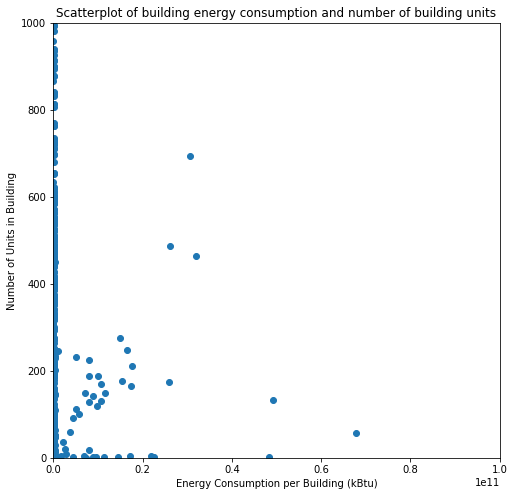

In [40]:
fig = pl.figure(figsize=(8,8)) 
ax = fig.add_subplot(111)

scatter = ax.scatter(x, y)
ax.set_xlabel("Energy Consumption per Building (kBtu)")
ax.set_ylabel("Number of Units in Building")
ax.set_ylim(0.0, 1000)
ax.set_xlim(0.0, 1.0* 1e11)
ax.set_title('Scatterplot of building energy consumption and number of building units');

Figure 4: Scatterplot of Energy Consumption per building and total number of units in building, excluding very big data points. Even so, most of the data points are still very clustered around the (0,0) region, implying that the effect of outliers is still very strong, or the fact that most buildings' energy consumption do not correlate that positively with number of units. 

# The magic of log scales!
**Please read the following vcarefully! this is the only opportunity I have to discuss this with you this year. **

Very often in science we will visualize data in log scale and model log data instead of the natural dataset (generally in log10).

In in log10 every order of magnitude is separate by a unit: log10(10) = 1, log10(100) = 2, log10(100000)=5 (basically log10 gives you the number of 0's in its argument, or the *order of magnitude*)





Text(0,0.5,'$log_{10}$(x)')

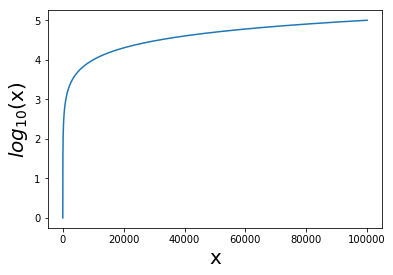

In [41]:
pl.plot(np.arange(100000), np.log10(np.arange(100000)), '-')
pl.xlabel("x", fontsize=20)
pl.ylabel(r"$log_{10}$(x)", fontsize=20)

The logarithm is a monotonic function : wherever its argument grows the function grows, wherever its argument decrease its log decrease. It's a function that grows fast when the argument is small and slowly when the argument is large, so it compresses the scale. 

Another property of the logarithm is that if the relationship between data is a power law (y = x^a) then the relationship between the log of the variables is linear! And we know that modeling things with linear models is easy!

	log_10(x^y) = y ∙ log_10(x)
    
And since power laws are very common in nature we often model with power laws, or with inear relationships in log space.

# Plot both NRG vs Units total and Units total vs NRG, both in log space

Surely there is a right way to think about which one is the independent and the dependent variable in this problem: do we think energy consumption causes occupancy or occupancy causes consumption?

You are going to have to limit the axis values or you will not see anything: 

    energy between (1000,1e10)

    units between (1,1000)

You can cut the axis to visualize the data like this, **but you will need to cut the data to remove datapoint outside of this range when you model to get a good model.**

to visualize the data in log scale you can use the dataframe plotting method with the argument 

    loglog=True


In [42]:
len(bblnrgdata)

6438

In [43]:
bblnrgdata.head()

,UnitsRes,UnitsTotal,YearBuilt,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),nrg
0,50,50,1914,1.007238e+09,68.7,95844.0,6584482.8
1,29,32,1928,1.013850e+09,87.4,206989.0,18090838.6
2,72,72,1923,1.021740e+09,140.4,52920.0,7429968.0
3,107,108,1931,1.008830e+09,96.5,98359.0,9491643.5
4,134,138,1910,1.008570e+09,36.4,154000.0,5605600.0


In [44]:
#cleaning the data 
 
bblnrgdata = bblnrgdata[bblnrgdata['nrg']<=1e10] #restricting to less than or equals to le10
bblnrgdata = bblnrgdata[bblnrgdata['nrg']>=1000]
bblnrgdata = bblnrgdata[bblnrgdata['UnitsTotal']<=1000] #restricting to less than or equals to 1000 units
bblnrgdata = bblnrgdata[bblnrgdata['UnitsTotal']>=1]

In [45]:
len(bblnrgdata)

4928

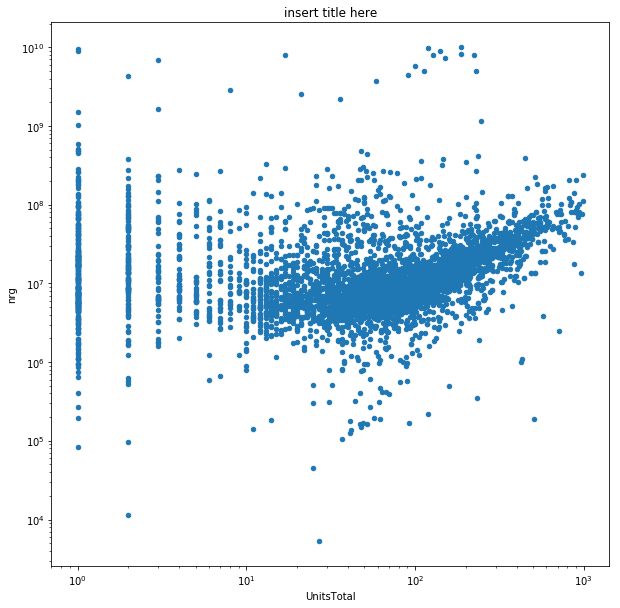

In [46]:
bblnrgdata.plot(x="UnitsTotal", 
            y="nrg", 
            kind='scatter', 
            figsize=(10,10), 
            title="insert title here",
            loglog=True);

Figure 6 : Scatterplot showing energy consumption per building against number of building units. There is generally a weak positive correlation between increasing units and energy consumption. Number of units seems to cluster around 10^1 to 10^2.5 .

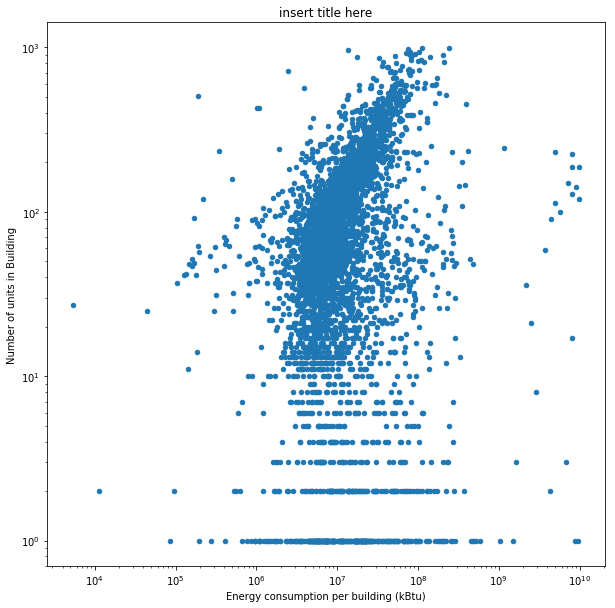

In [47]:
ax = bblnrgdata.plot(x="nrg", 
            y="UnitsTotal", 
            kind='scatter', 
            figsize=(10,10), 
            title="insert title here",
            loglog=True)

ax.set_xlabel("Energy consumption per building (kBtu)")
ax.set_ylabel("Number of units in Building");

Figure 7 : Scatterplot showing number of buildings in unit against energy consumption per building. There seems to be a week correlation between increasing energy consumption and number of units in a building, with most energy consumption clustered between the 10^6 and 10^8 region.

# Fit the data with a line in log space:  

**make sure you print the summary and plot the data and the model**

In [75]:
# log energy and log units is from later portions
OLS = smf.ols(formula='logEnergy ~ logUnits ', data=bblnrgdataCut).fit()
OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              logEnergy   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     93.29
Date:                Tue, 27 Nov 2018   Prob (F-statistic):           7.05e-22
Time:                        23:44:54   Log-Likelihood:                -7401.8
No. Observations:                4928   AIC:                         1.481e+04
Df Residuals:                    4926   BIC:                         1.482e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     15.8289      0.042    374.550      0.000        15.746    15.912
logUnits       0.0984      0.010      9.659      0.000         0.078     0.118
==============================================================================
Omnibus:                     1256.913   Durbin-Watson:                   1.644
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10059.101
Skew:                           0.993   Prob(JB):                         0.00
Kurtosis:                       9.711   Cond. No.                         11.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

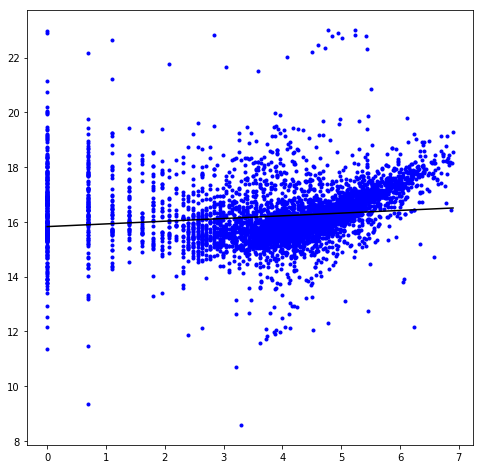

In [76]:
pl.figure(figsize=(8,8))

pl.plot(bblnrgdataCut['logUnits'] ,bblnrgdataCut['logEnergy'] ,'b.')
pl.plot(bblnrgdataCut['logUnits'],OLS.predict(bblnrgdataCut), 'k')

In [77]:
OLS2 = smf.ols(formula='logUnits ~ logEnergy ', data=bblnrgdataCut).fit()
OLS2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logUnits   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     93.29
Date:                Tue, 27 Nov 2018   Prob (F-statistic):           7.05e-22
Time:                        23:45:43   Log-Likelihood:                -9007.3
No. Observations:                4928   AIC:                         1.802e+04
Df Residuals:                    4926   BIC:                         1.803e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.7980      0.318      2.513      0.012         0.175     1.421
logEnergy      0.1888      0.020      9.659      0.000         0.151     0.227
==============================================================================
Omnibus:                      899.905   Durbin-Watson:                   0.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1488.609
Skew:                          -1.232   Prob(JB):                         0.00
Kurtosis:                       4.087   Cond. No.                         242.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

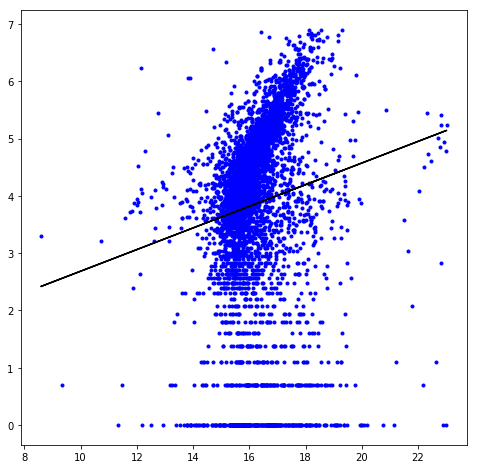

In [78]:
pl.figure(figsize=(8,8))

pl.plot(bblnrgdataCut['logEnergy'] ,bblnrgdataCut['logUnits'] ,'b.')
pl.plot(bblnrgdataCut['logEnergy'],OLS2.predict(bblnrgdataCut), 'k')

## Model NRG as a linear function of number of units in the building 
Certainly there is a right way to think about this: which is the *independent* and the *dependent* variable? which do we think causes which? do units "cause"energy consumption or vice versa? please answer below

**I think the units cause energy consumption, not the other way round. Therefore, the independent variable is energy consumption, while the dependent variable is units.**

However, indulge me and try both models: models (nrg vs units total & units total vs nrg). 

- create the models with statsmodels
- print the model summary
- plot the data and the fit
- Check and comment on how the following model diagnostics change: 
        R^2 and LogLikelihood
        
(remember to use only the data in the appropriate range, see the previous step)

### Energy vs Units

In [48]:
OLS1 = smf.ols(formula='UnitsTotal ~ nrg', data=bblnrgdata).fit()
OLS1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             UnitsTotal   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.238
Date:                Tue, 27 Nov 2018   Prob (F-statistic):              0.266
Time:                        23:41:52   Log-Likelihood:                -30751.
No. Observations:                4928   AIC:                         6.151e+04
Df Residuals:                    4926   BIC:                         6.152e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    101.2347      1.778     56.931      0.000        97.749   104.721
nrg         4.463e-09   4.01e-09      1.113      0.266      -3.4e-09  1.23e-08
==============================================================================
Omnibus:                     3100.220   Durbin-Watson:                   1.882
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            33984.219
Skew:                           2.910   Prob(JB):                         0.00
Kurtosis:                      14.473   Cond. No.                     4.46e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.46e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

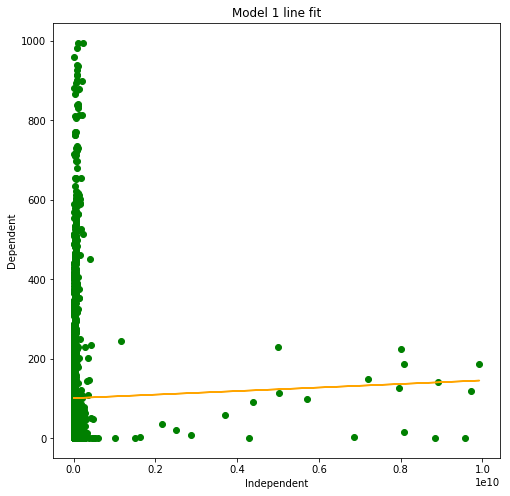

In [49]:
pl.figure(figsize=(8,8))
pl.plot(bblnrgdata['nrg'],bblnrgdata['UnitsTotal'],'go')
pl.plot(bblnrgdata['nrg'], OLS1.predict(bblnrgdata),'-', color='orange')
pl.xlabel('Independent')
pl.ylabel('Dependent')
pl.title('Model 1 line fit');

### Units vs Energy

In [50]:
OLS2 = smf.ols(formula='nrg ~ UnitsTotal', data=bblnrgdata).fit()
OLS2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    nrg   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.238
Date:                Tue, 27 Nov 2018   Prob (F-statistic):              0.266
Time:                        23:41:53   Log-Likelihood:            -1.0508e+05
No. Observations:                4928   AIC:                         2.102e+05
Df Residuals:                    4926   BIC:                         2.102e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   4.092e+07   8.11e+06      5.045      0.000       2.5e+07  5.68e+07
UnitsTotal  5.628e+04   5.06e+04      1.113      0.266     -4.29e+04  1.55e+05
==============================================================================
Omnibus:                    10225.676   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         23368552.489
Skew:                          17.821   Prob(JB):                         0.00
Kurtosis:                     338.466   Cond. No.                         207.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

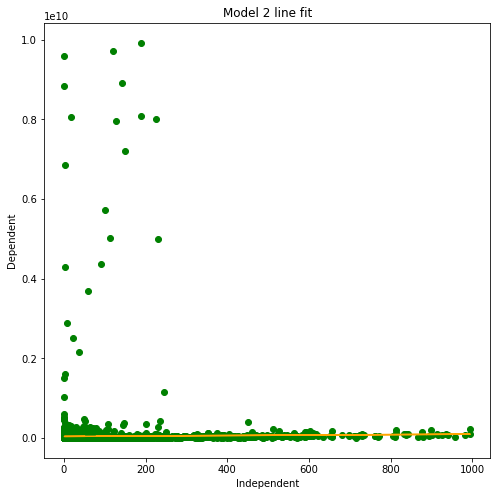

In [51]:
pl.figure(figsize=(8,8))
pl.plot(bblnrgdata['UnitsTotal'],bblnrgdata['nrg'],'go')
pl.plot(bblnrgdata['UnitsTotal'], OLS2.predict(bblnrgdata),'-', color='orange')
pl.xlabel('Independent')
pl.ylabel('Dependent')
pl.title('Model 2 line fit');

# Second degree polynomial fit

model the data with a slightly more complex model: 
    
    y = ax*x + bx + c, 

instead of 
        
    y = bx + c
    
**make sure you print the summary and plot the data and the model**


In [52]:
bblnrgdataCut = bblnrgdata #assumed because i have cleaned the dataset earlier at the top
bblnrgdataCut['logEnergy'] = np.log(bblnrgdata['nrg'])
bblnrgdataCut['logUnits'] = np.log(bblnrgdata['UnitsTotal'])

bblnrgdataCut.head()

,UnitsRes,UnitsTotal,YearBuilt,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),nrg,logEnergy,logUnits
0,50,50,1914,1.007238e+09,68.7,95844.0,6584482.8,15.700226,3.912023
1,29,32,1928,1.013850e+09,87.4,206989.0,18090838.6,16.710916,3.465736
2,72,72,1923,1.021740e+09,140.4,52920.0,7429968.0,15.821032,4.276666
3,107,108,1931,1.008830e+09,96.5,98359.0,9491643.5,16.065922,4.682131
4,134,138,1910,1.008570e+09,36.4,154000.0,5605600.0,15.539277,4.927254


In [53]:
bblnrgdataCut['logUnits2'] = bblnrgdataCut['logUnits'] **2

In [54]:
bblnrgdataCut['logEnergy10'] = np.log10(bblnrgdataCut['nrg'])
bblnrgdataCut['logUnits10'] = np.log10(bblnrgdataCut['UnitsTotal'])

In [71]:
bblnrgdataCut['logUnits102'] = bblnrgdataCut['logUnits10']**2

In [72]:
bblnrgdataCut.sort_values(by='logUnits10' , inplace=True)

In [73]:
OLS3 = smf.ols(formula='logEnergy10 ~ logUnits10 + I(logUnits102)',data=bblnrgdataCut).fit()
OLS3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            logEnergy10   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     462.5
Date:                Tue, 27 Nov 2018   Prob (F-statistic):          8.18e-185
Time:                        23:43:07   Log-Likelihood:                -2913.8
No. Observations:                4928   AIC:                             5834.
Df Residuals:                    4925   BIC:                             5853.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept          7.2570      0.022    335.352      0.000         7.215     7.299
logUnits10        -0.7355      0.031    -23.977      0.000        -0.796    -0.675
I(logUnits102)     0.3129      0.011     28.572      0.000         0.291     0.334
==============================================================================
Omnibus:                     1409.556   Durbin-Watson:                   1.916
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18017.884
Skew:                           1.000   Prob(JB):                         0.00
Kurtosis:                      12.151   Cond. No.                         25.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

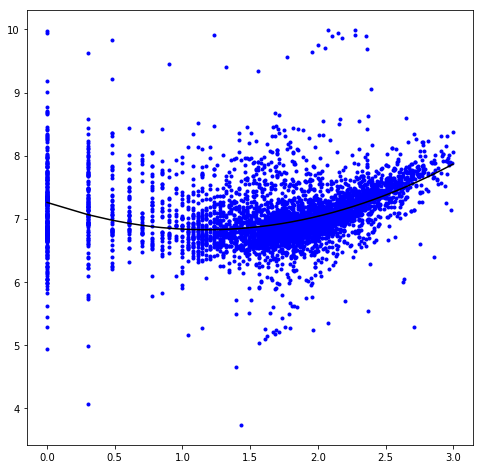

In [74]:
pl.figure(figsize=(8,8))
pl.plot(bblnrgdataCut['logUnits10'].sort_values() , bblnrgdataCut['logEnergy10'] , 'b.')

pl.plot(bblnrgdataCut['logUnits10'].sort_values(), OLS3.predict(bblnrgdataCut) , 'k' )

Figure: 

# calculate the chi square and likelihood of your model

## Define a chisquare function

In [63]:
def chi2(data, model, errors = None):
    '''Calculates the chi sq given data, model and errors
    Arguments:
    data: series of datapoints (endogenous variable)
    model: series of predicted values corresponding to the observed data
    errors: serie of errors (optional). 
    If errors are not passes all errors are set to 1
    '''
    if errors is None:
        ones = np.ones(pd.Series(len(data)))
        return np.sum(((data - model) **2)/ones **2)
    
    else:
        return np.sum(((data - model) **2))

## Define and calculate errors

Assume Poisson statistics and calculate the errors accordingly. Remember that you have used 2 quantities combined linearly to calculate the energy (your *dependent* variable) , so the errors combine in quadrature!

    Total Error = sqrt(error1^2 + error2^2)
    
Your *independent* variable has uncertainty also! assume it is also Poissonian

** propagation of errors on the log:**
https://en.wikipedia.org/wiki/Propagation_of_uncertainty#Linear_combinations

$f=a\log _{10}(A)$

$\sigma _{f}\approx \left(a{\frac {\sigma _{A}}{A\ln(10)}}\right)$

In [67]:
component_1 = bblnrgdataCut['logUnits10_errors']

component_2 = 2 * bblnrgdataCut['logUnits10'].values  * bblnrgdataCut['logUnits10_errors']
total_error = np.sqrt(bblnrgdataCut['logUnits10_errors'] **2)


bblnrgdataCut['logEnergy10_errors'] = total_error

bblnrgdataCut.head()

,UnitsRes,UnitsTotal,YearBuilt,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),nrg,logEnergy,logUnits,logUnits2,logEnergy10,logUnits10,logUnits102,logUnits10_errors,logEnergy10_errors2,errorsnrg,errorsunits,logEnergy10_errors
2482,0,1,1985,1.013050e+09,97.8,165000.0,16137000.0,16.596625,0.0,0.0,7.207823,0.0,0.0,0.434294,0.000108,Ellipsis,Ellipsis,0.434294
3115,0,1,1978,1.011190e+09,430.1,65461.0,28154776.1,17.153228,0.0,0.0,7.449552,0.0,0.0,0.434294,0.000082,Ellipsis,Ellipsis,0.434294
3119,0,1,1965,1.008900e+09,11.3,36344.0,410687.2,12.925587,0.0,0.0,5.613511,0.0,0.0,0.434294,0.000678,Ellipsis,Ellipsis,0.434294
2007,0,1,1941,1.005470e+09,52.0,73733.0,3834116.0,15.159449,0.0,0.0,6.583665,0.0,0.0,0.434294,0.000222,Ellipsis,Ellipsis,0.434294
3124,0,1,2001,1.017350e+09,78.7,77623.0,6108930.1,15.625262,0.0,0.0,6.785965,0.0,0.0,0.434294,0.000176,Ellipsis,Ellipsis,0.434294


Text(0.5,0.98,'Total units in building as function of Energy')

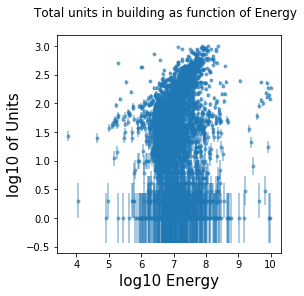

In [68]:
ax1 = plt.subplots(figsize=(4,4))
matplotlib.pyplot.errorbar(bblnrgdataCut.logEnergy10, bblnrgdataCut.logUnits10, 
            yerr=bblnrgdataCut.logUnits10_errors, fmt='.',
            alpha=0.5)
plt.ylabel("log10 of Units", fontsize=15)
plt.xlabel("log10 Energy", fontsize=15)
pl.suptitle("Total units in building as function of Energy")

In [69]:
sns.reset_orig()
import matplotlib.pyplot as plt
ax1 = plt.subplots(figsize=(8,8))
matplotlib.pyplot.errorbar(bblnrgdataCut.logUnits10, bblnrgdataCut.logEnergy10, 
             yerr=bblnrgdataCut.logEnergy10_errors, fmt='.',
            alpha=0.5)
plt.ylabel("log10 of Energy", fontsize=15)
plt.xlabel("log10 Units", fontsize=15)
pl.suptitle("Total units in building as function of Energy")

NameError: name 'sns' is not defined

In [ ]:
ax1 = plt.subplots(figsize=(8,8))
matplotlib.pyplot.errorbar(bblnrgdataCut.logUnits10, bblnrgdataCut.logEnergy10, 
            xerr=bblnrgdataCut.logUnits10_errors ,              
            yerr=bblnrgdataCut.logEnergy10_errors, fmt='.',
            alpha=0.5)
plt.ylabel("log10 of Energy", fontsize=15)
plt.xlabel("log10 Units", fontsize=15)
pl.suptitle("Total units in building as function of Energy")

## Make 3 plots: one with x errors, one with y errors, one with x and y errors. 

with pylab you can do it with pl.errorbar(x, y, xerr=xerror, yerr=yerror)

In [ ]:
#I could also include errors for number of units
fig2 = plt.figure(constrained_layout=True, figsize=(15,15))

gs1 = gridspec.GridSpec(3, 3, figure=fig2)
gs1.update(left=0.68, right=0.68, wspace=0.2)


ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=1)
ax1.errorbar(np.log10(bblnrgdataCut.nrg), np.log10(bblnrgdataCut.UnitsTotal), 
            yerr=bblnrgdataCut.errorsunits, fmt='.',
            alpha=0.5)
ax1.set_ylabel("log10 of Units", fontsize=15)
ax1.set_xlabel("log10 Energy", fontsize=15)
pl.suptitle("Total units in building as function of Energy")


ax2 = plt.subplot2grid((3, 3), (0, 1), colspan=1)
ax2.errorbar(np.log10(bblnrgdataCut.UnitsTotal), np.log10(bblnrgdataCut.nrg), 
            yerr=bblnrgdataCut.errorsnrg, fmt='.',
            alpha=0.5)
ax2.set_xlabel("log10 of Units", fontsize=15)
ax2.set_ylabel("log10 Energy", fontsize=15)

ax4 = plt.subplot2grid((3, 3), (1, 0), colspan=2, rowspan=2)
ax4.errorbar(np.log10(bblnrgdataCut.UnitsTotal), np.log10(bblnrgdataCut.nrg), 
            yerr=bblnrgdataCut.errorsnrg,
           xerr=bblnrgdataCut.errorsunits, alpha=0.5, fmt='.')
ax4.set_xlabel("log10 of Units", fontsize=15)
ax4.set_ylabel("log10 Energy", fontsize=15)
ax4.set_ylim(5,11)

print ("The largest error bar is for")
bblnrgdataCut[bblnrgdataCut.errorsnrg == bblnrgdataCut.errorsnrg.max()]


Figure 7: The same as Figure 5 and 6, but with errorbars. In the top panel the errors on the Units in the building are plotted, in the bottom panels the errors on the energy are plotted, but they are too small to see,  and both on the right side panel. The bottom right panel is a zoom-in of the bottom left panel. Errors are measured by assuming Poisson statistics at the measurement level for energy per square foot, squarefootage, and for the number of units, and propagate properly to the log space. Notice that we do not know what the units of energy really represent: the Poisson statitics should be applied to the measured counts, but the enrgy consumption is a continuous variable, only discretized by the act of measuring it. 

IMPORTANT! errors as the square root of the measurement (Poisson statistics) are ONLY meaningful when you are potting dimensionless quantoities! here it is preposterous to assume that the errors are the square root of the measurement. WHY? because then if I express my energy by sq meter, instead of sq feet, I get a different error on the measurement for the same measurement - which makes no sense! However, in this case, I am not using the errors to create the model (no WLS for example) so this error allows me to compare uncertainty on the datapoints. Even if the errors are different, under linear transformations (changes of units for example) the relationship between errors on 2 datapoints will be preserved. 

Notice: No points are taken off if other errors are used, including the sqrt of the log energy, and the correct errors propagation in the log on errors calculated, however, as the sqrt of the tot energy per building, but the errors are in the measured quantities, so this is the proper way to obtain them. In addition the units of energy are extremely large, thus the errors in percentage on the energy are extremely small. These errors are likely to be underestmated due to our ignorance of the details of the experiment.

## Add the errors and calculate the chi square


### calculate the degrees of freedom of this model

In [ ]:
#degrees of freedom: number of observations - number of model parameters
# note: these are reported as dof of the residuals in the statsmodels fit summary, but jsut to make sure let's calculate them
dof = ...
print ("degrees of freedom:" , dof)

In [ ]:
print ("Units vs Energy residuals (no errors include): %.2f"%\
       (chi2(np.log10(bblnrgdataCut.UnitsTotal), linmodel_0.predict()) / 
        float(dof)))

print ("Units vs Energy chi square per DOF w independent variable error only: %.2f"%\
       (chi2(np.log10(bblnrgdataCut.UnitsTotal), linmodel_0.predict(), 
            errors = bblnrgdataCut.errorsnrg) / dof))

print ("Units vs Energy chi square per DOF : %.2f"%\
       (chi2(np.log10(bblnrgdataCut.UnitsTotal), linmodel_0.predict(), 
            errors = np.sqrt(bblnrgdataCut.errorsnrg**2 + 
                             bblnrgdataCut.errorsunits**2))  / dof))


In [ ]:
print ("Energy vs Units residuals (no errors include): %.2f"%\
       (chi2(np.log10(bblnrgdataCut.nrg), linmodel_1.predict()) / dof))

print ("Energy vs Units chi square per DOF w independent variable error only: %.2f"%\
       (chi2(np.log10(bblnrgdataCut.nrg), linmodel_1.predict(), 
            errors = bblnrgdataCut.errorsnrg) / dof))

print ("Energy vs Units chi square per DOF : %.2f"%\
       (chi2(np.log10(bblnrgdataCut.nrg), linmodel_1.predict(), 
            errors = np.sqrt(bblnrgdataCut.errorsnrg**2 + 
                             bblnrgdataCut.errorsunits**2))  / dof))


### Compare the models using the  chi square:
discuss

If the result of the units vs energy surprises you plot the influence plot for the model. Except the default statsmodels influence plot is a bit of a mess, cause so many points have high leverage, and thus high influence, that the labels cover the span of the plot and make it useless. One could relatively easily engineered one's own influence plot, but instead for the purpose of this discussion comparing the units vs energy with the energy vs units influence plot is sufficient to show how many more points with high **leverage** are in the first plot than in the second - look at the axis range! What is happening is that the distribution of points along the exogenous variable is much better suited to a line fit in the energy vs units plot. You want a large spread in the exogenous variable. In the units vs energy most values of the exogenous variable (energy in this case) are clustered in a small range, while the endogenous variable varies greatly for those points. So the core of the distribution has low predictive power, and the importance of the "outliers" with high and low energy values is enhanced in the fit. 

Figure 10: ...

# Comparing the linear and curve fit with Likelihood Ratio LR test; we require a significance $\alpha=0.05$

** The curve fit and linear fit od the Energy vs Units can be compared with LR test because they are nested models**

** The difference in the number of degrees of freedom is 1, so the LR statistics will follow a $\chi^2$ distribution with 1 DOF.**


LR = ...
**reject / not reject...**

## EC 1 Plotting the likelihood surface (assuming gaussian statistics)

when you assume Gaussian statistics the log likelihood is the chi square, so you can plot the chi square from the function you created earlier!

* choose a reasonable range of a, b, and c for your parameters. 
* calculate the chisquare for each value in the range: this can be done in a nested for loop
* save the value of the chi square and plot it as a surface

in pylab you can plot surfaces with pl.imshow()


### creating a function that returns the likelihood value on a grid
We already have the function! If we assume a Gaussian distribution then the likelihood is the chi square (not exactly, but it is a linear function of the chi squared, which means that maximizing the log likelihood is the same as minimizing the chi square).
this is a brute force minimization, which is escruciatingly slow and should not be done due to its inefficiency, but it is a transparent code that allows you to see what it means to maximize the likelihood surface (which is equivalent to minimizing the sum of the residuals squared, or the chi squared if errors are used)

### calculating and plotting the loglikelihood in a 2D sensible range of values
plot is for 
    - chi square calculated with no errors (i.e. sum of residuals squared)
    - chi squared with errors
    
compare the surfaces

In [ ]:
fig = pl.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax1.set_title ("log likelihood surface, no errors", fontsize = 22)
pl.imshow(np.log(resids_noerror), extent = [-50,50,100,-100], aspect=0.5)
ax1.set_xlabel('slope', fontsize = 22)
ax1.set_ylabel('intercept', fontsize = 22)
pl.colorbar()

ax2 = fig.add_subplot(122)
ax2.set_title ("log likelihood surface", fontsize = 22)
pl.imshow(np.log(resids), extent = [-50,50,100,-100], aspect=0.5)
ax2.set_xlabel('slope', fontsize = 22)
ax2.set_ylabel('intercept', fontsize = 22)
pl.colorbar();


Figure 11: ...

In [ ]:
#leave
#plotting the difference between the 2 likelihood surfaces to see if the minimum is in the right place
ax1 = pl.figure(figsize=(10,10)).add_subplot(111)
ax1.set_title ("log likelihood surface difference \n between model with and without errors", fontsize = 22)
pl.imshow(np.abs(np.log(resids) - np.log(resids_noerror)), extent = [-50,50,100,-100], aspect=0.5, cmap='bone')
ax1.set_xlabel('slope', fontsize = 22)
ax1.set_ylabel('intercept', fontsize = 22)
pl.colorbar();


Figure 12: ...

# EXTRA CREDIT: a plot of anything related to these data

In [ ]:
ax = pl.figure(figsize=(10,10)).add_subplot(111)
bblnrgdataCut['YearBuilt'][bblnrgdataCut['YearBuilt']<1800]=1800

bblnrgdataCut.plot(kind='scatter', x='nrg', y='UnitsTotal', 
                fontsize=22, colormap='gist_earth', alpha = 0.5, 
                marker='o',  figsize=(16, 14), loglog=True,  
                xlim=(1000,1e11), ylim=(1,1000), ax = ax,
                c= dt.datetime.today().year - bblnrgdataCut['YearBuilt'], 
                s=bblnrgdataCut['UnitsTotal']/bblnrgdataCut['UnitsRes'] * 100)
pl.title('Units vs Energy consumption (log-log plot)\nColor maps Age in years, Size maps total/residential units', 
         fontsize=18)
pl.ylabel("total number of units", fontsize=22)
pl.xlabel("total energy consumption (kBtu)", fontsize=22);


Figure 13: Plot of Number of Units as a function of energy consumption for all NYC buildings with self reported energy consumption in the Local Law 84 database. The color of each datapoint representes the age: darker colors are buildings of more recent construction. The size of the mark represents the inverse of the fraction of residential units in the building (large datapoints indicate a small fraction of residential units, i.e. a comercial building). 

There is a weak color gradient where younger buildings dominate the higher portion of the plot. This could be interpreted as higher efficiency: at the same energy consumption younger buildings host more people. Or it could be driven by architectural changes: a trend to host the same number of people segregating them in more smaller units.

Aside from a few obvious outliers there is no obvious trend in fraction of residential units with building age, energy, or total number of units